# Analyze model

First: Create model similar to `exp_regression.ipynb`

In [1]:
# To make relative imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED, FIG_DIR, COURSES, SECTORS
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalaries
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

inflationAdjasutedBruttoSalary = getInflationAdjustedBruttoSalaries(SECTORS)
salaries = getSalaries()

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
3798.0 -> 3712.609970674487
3818.5 -> 3732.649071358749
3905.0 -> 3713.2337559097946
3951.5 -> 3757.4502398149943
4001.5 -> 3797.4000460725265
4072.5 -> 3864.7786299213703
4093.0 -> 3841.971325187983
4108.0 -> 3856.051356919676
4194.0 -> 3840.7579240793984
4268.5 -> 3908.9831184866266
4365.5 -> 3911.754635400449
4488.5 -> 4021.9701479773025
4474.0 -> 3945.8437621538624
4500.5 -> 3969.2154339681397
4554.5 -> 3984.961039163173
4653.0 -> 4071.1436415031826
4724.0 -> 4104.533377567224
4799.5 -> 4170.132926679486
4769.0 -> 4127.123950771447
4849.5 -> 4196.789179967736
4905.5 -> 4174.2890

/Users/abdallahabdul-latif/Desktop/Universität Tübingen/5.Semester/Data Literacy/Neuer Ordner/AnalysingStudentDevelopment/src/dataLoading.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/abdallahabdul-latif/Desktop/Universität Tübingen/5.Semester/Data Literacy/Neuer Ordner/AnalysingStudentDevelopment/src/dataLoading.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Test model accuracy
Delete last 2 timesteps and use them as a test set.

In [3]:
PAST_STEPS = 4
PREDICTION_STPES = 10

In [4]:
completeData = np.column_stack((totalStudents, inflationAdjasutedBruttoSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STPES])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'sallary', 'graduates'])

In [5]:
model = VAR(completeDataDF)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = trainData[-PAST_STEPS:]  # Use the last available values as lagged values
forecast, lower, upper = results.forecast_interval(lagged_values, steps=PREDICTION_STPES, alpha=0.05)
print(forecast)

[[ 6524.11272424  3869.06007798 51971.80490197]
 [ 6815.87279316  3923.83429325 52161.39398183]
 [ 6154.248036    3892.91648089 50146.6601648 ]
 [ 6639.15702287  3954.97581676 50433.97370661]
 [ 6152.80924358  3923.37718701 48765.85262457]
 [ 6688.06614845  3964.73352673 48067.63321077]
 [ 6149.15956296  3918.52028647 46013.64760371]
 [ 6640.20319439  3956.89982477 45762.41061636]
 [ 6045.07742212  3906.07296163 44939.49503705]
 [ 6486.29192239  3941.90676105 45317.04452315]]


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[  56.88727576    7.8226294   123.19509803]
 [  55.87279316   10.68946905   66.39398183]
 [  77.751964     23.08996967 1052.3398352 ]
 [  71.84297713   17.74026245  765.02629339]
 [  30.80924358    1.54463767  379.14737543]
 [  64.06614845    0.78484083 1077.36678923]
 [ 105.15956296   36.38016394  583.35239629]
 [  43.20319439   28.62379619  834.58938364]
 [  89.92257788    2.67512644  854.49503705]
 [ 177.70807761   21.06632564 1232.04452315]]

These are the percentage differences between the predicted and the actual values
[[0.86441689 0.20259384 0.23648162]
 [0.82652061 0.27316825 0.1274479 ]
 [1.24762458 0.59666679 2.05539138]
 [1.07052566 0.45057661 1.49422116]
 [0.50325455 0.03935461 0.77148718]
 [0.96718219 0.01979947 2.19222055]
 [1.73990012 0.91987559 1.25190977]
 [0.65489153 0.71819412 1.79107965]
 [1.46573069 0.06843947 1.93828975]
 [2.66668784 0.53157882 2.79470233]]


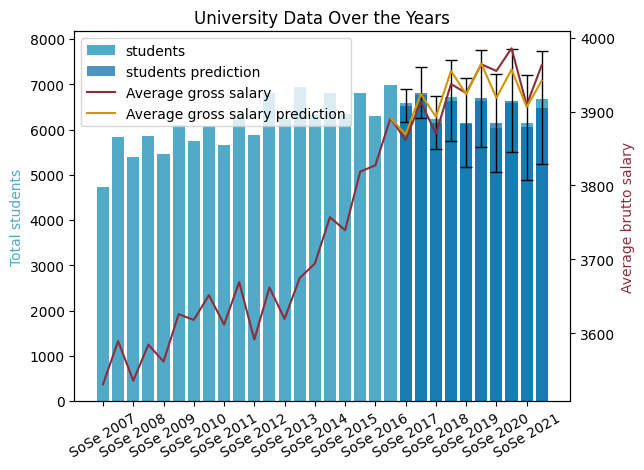

In [7]:
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)

ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STPES], trainData[:, 0], color=COL_STUDENT, label='students')
ax1.bar(interestingYears[-PREDICTION_STPES:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], color=COL_STUDENT_PRED, alpha=0.7, label='students prediction')
ax1.errorbar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], yerr=upper[:, 0] - lower[:, 0], fmt='none', ecolor='k', elinewidth=1, capsize=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylabel('Average brutto salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average gross salary')
ax2.plot(interestingYears[-PREDICTION_STPES -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average gross salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])
fig.savefig(FIG_DIR + f"/prediction_{PAST_STEPS}.pdf")
plt.show()

Documentation Link: [statsmodel](https://www.statsmodels.org/dev/vector_ar.html#statistical-tests)

In [8]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

<Axes: >

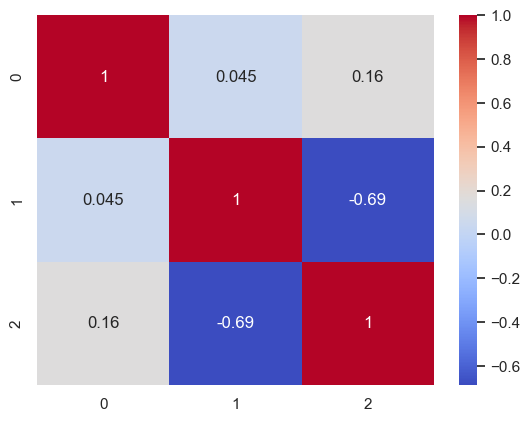

In [9]:
import seaborn as sns
resudiuals = results.resid
correlationMatrix = np.corrcoef(resudiuals, rowvar=False)
sns.set(style="white")
sns.heatmap(correlationMatrix, cmap="coolwarm", annot=True, )

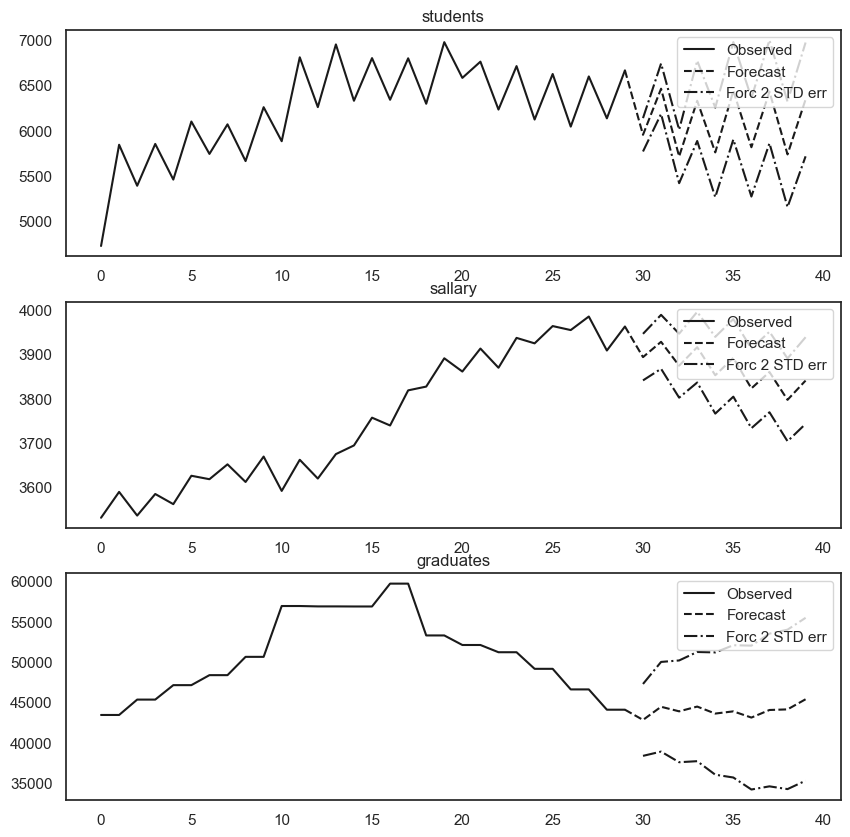

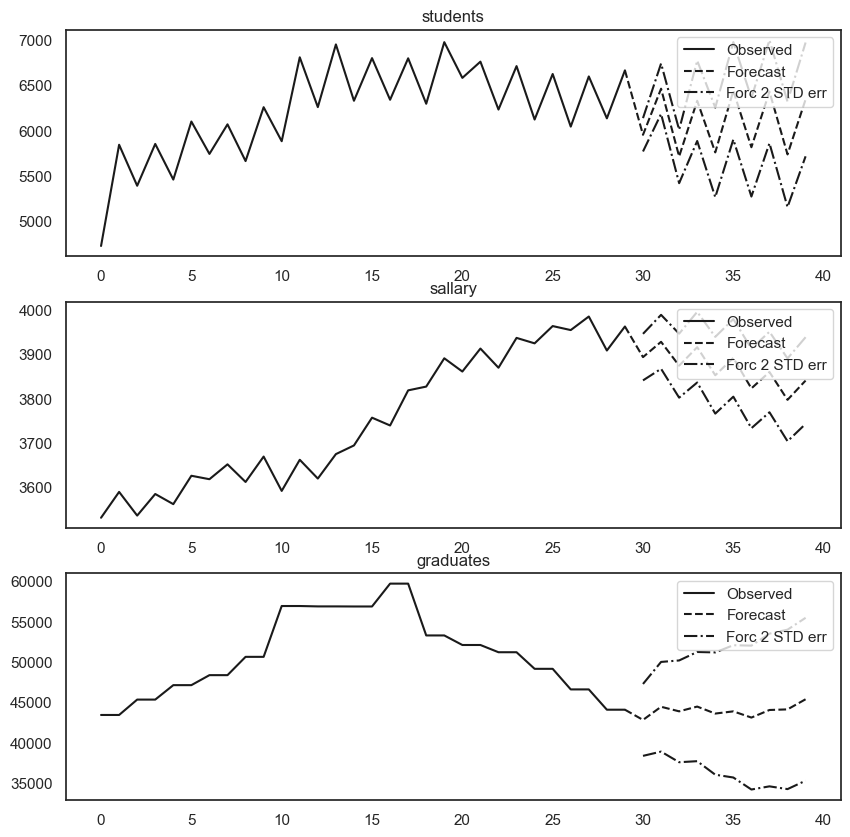

In [10]:
results.plot_forecast(10)


In [11]:
results.test_normality()